<a href="https://colab.research.google.com/github/sebaspv/MoNet/blob/main/MoNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [3]:
# image definition constants
GEN_RES = 2
GEN_SQUARE = 32*GEN_RES # 96*96 images
COLOR_CHANNELS = 3

PR_ROWS = 4
PR_COLS = 7
PR_MARGIN = 16

SEED_SIZE = 100 # vector size

DATA_PATH = '/content/drive/My Drive/monet'
EPOCHS = 100
BATCH_SIZE = 32
BUFFER_SIZE = 60000


In [4]:
# preprocess image data
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GEN_SQUARE}_{GEN_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  monet_path = DATA_PATH
  for filename in tqdm(os.listdir(monet_path)):
      path = os.path.join(monet_path,filename)
      image = Image.open(path).resize((GEN_SQUARE,GEN_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GEN_SQUARE,GEN_SQUARE,COLOR_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/drive/My Drive/monet/training_data_64_64.npy
Loading previous training pickle...


In [5]:
full_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def generator_build(size_seed, channels):
  model = Sequential()
  model.add(Dense(4096, activation = 'relu', input_dim = size_seed))
  model.add(Reshape((4, 4, 256)))
  model.add(UpSampling2D())
  model.add(Conv2D(256, kernel_size = (3, 3), padding = 'same'))
  model.add(BatchNormalization(momentum = 0.8))
  model.add(Activation('relu')) # activation after batch normalization
  model.add(UpSampling2D())
  model.add(Conv2D(256, kernel_size = (3, 3), padding = 'same'))
  model.add(BatchNormalization(momentum = 0.8))
  model.add(Activation('relu'))

  # output block
  model.add(UpSampling2D())
  model.add(Conv2D(128,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))

  model.add(UpSampling2D(size=(GEN_RES,GEN_RES)))
  model.add(Conv2D(128,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))

  # final layer
  model.add(Conv2D(channels,kernel_size=3,padding="same"))
  model.add(Activation("tanh"))

  return model

In [7]:
def build_discriminator(image_shape):
  model = Sequential()
  model.add(Conv2D(32, kernel_size = (3, 3), input_shape = image_shape, padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2)) # leaky relu works better for discriminators
  model.add(Dropout(0.25))

  model.add(Conv2D(64, kernel_size = (3, 3), strides = (2, 2), padding = 'same'))
  model.add(ZeroPadding2D(padding = ((0,1),(0,1))))
  model.add(BatchNormalization(momentum = 0.8))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Dropout(0.25))
  model.add(Conv2D(128, kernel_size = (3, 3), strides = (2, 2), padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(0.25))
  model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(0.25))
  model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  # final block
  model.add(Dropout(0.25))
  model.add(Flatten())
  # final decision layer
  model.add(Dense(1, activation='sigmoid'))

  return model

In [8]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PR_MARGIN + (PR_ROWS * (GEN_SQUARE+PR_MARGIN)), 
      PR_MARGIN + (PR_COLS * (GEN_SQUARE+PR_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PR_ROWS):
      for col in range(PR_COLS):
        r = row * (GEN_SQUARE+16) + PR_MARGIN
        c = col * (GEN_SQUARE+16) + PR_MARGIN
        image_array[r:r+GEN_SQUARE,c:c+GEN_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

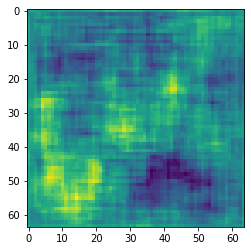

In [9]:
generator = generator_build(SEED_SIZE, COLOR_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])
# output of not trained generator

In [10]:
image_shape = (GEN_SQUARE,GEN_SQUARE,COLOR_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision) # decision over the generator's not trained image

tf.Tensor([[0.49908483]], shape=(1, 1), dtype=float32)


In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# loss functions for the generator and discriminator

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(0.00015,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.00015,0.5)

In [13]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [14]:
# measure training time
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [15]:


def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PR_ROWS * PR_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  time_passed = hms_string(elapsed)
  print (f'Training time: {time_passed}')



In [16]:
train(full_dataset, EPOCHS)

Epoch 1, gen loss=1.492239236831665,disc loss=1.1680930852890015, {hms_string(epoch_elapsed)}
Epoch 2, gen loss=2.011931896209717,disc loss=1.156425952911377, {hms_string(epoch_elapsed)}
Epoch 3, gen loss=2.0850937366485596,disc loss=1.03692626953125, {hms_string(epoch_elapsed)}
Epoch 4, gen loss=2.1516261100769043,disc loss=0.8889337778091431, {hms_string(epoch_elapsed)}
Epoch 5, gen loss=2.4447455406188965,disc loss=0.8348783850669861, {hms_string(epoch_elapsed)}
Epoch 6, gen loss=1.5848560333251953,disc loss=1.364079236984253, {hms_string(epoch_elapsed)}
Epoch 7, gen loss=1.6595146656036377,disc loss=1.3984894752502441, {hms_string(epoch_elapsed)}
Epoch 8, gen loss=1.1004832983016968,disc loss=1.4638794660568237, {hms_string(epoch_elapsed)}
Epoch 9, gen loss=1.3984780311584473,disc loss=0.9913135170936584, {hms_string(epoch_elapsed)}
Epoch 10, gen loss=1.195038080215454,disc loss=1.1163159608840942, {hms_string(epoch_elapsed)}
Epoch 11, gen loss=1.6812254190444946,disc loss=1.269926

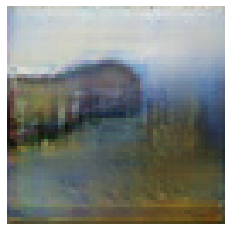

In [21]:

# generate and plot a fake image
noise = np.random.rand(1, 100)
generated_images = generator.predict(noise)

generated_images = 0.5 * generated_images + 0.5

image_count = 0
plt.axis(False)
gen_image = generated_images[0]*255
plt.imshow(gen_image.astype('uint8'))
# this generated image actually looks a bit like Monet's paintings! Well, at least the colors look alike :)